# Chapter 3 - Classification

### MNIST

In [1]:
import pandas as pd
import numpy as np

In [2]:
import os, itertools

In [3]:
from sklearn import datasets

Scikit-Learn provides many helper functions to download popular datasets.

In [ ]:
from sklearn.datasets import fetch_mldata

mnist = fetch_mldata("MNIST original")
# mnist = datasets.load_digits()

D:\Anaconda3\envs\cv_course\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function fetch_mldata is deprecated; fetch_mldata was deprecated in version 0.20 and will be removed in version 0.22. Please use fetch_openml.
  warnings.warn(msg, category=DeprecationWarning)
D:\Anaconda3\envs\cv_course\lib\site-packages\sklearn\utils\deprecation.py:85: DeprecationWarning: Function mldata_filename is deprecated; mldata_filename was deprecated in version 0.20 and will be removed in version 0.22. Please use fetch_openml.
  warnings.warn(msg, category=DeprecationWarning)


In [ ]:
mnist

Datasets loaded by Scikit-Learn generally have a similar dictionary structure including:

* A `DESCR` key describing the dataset
* A `data` key containing an array with one row per instance and one column per feature
* A `target` key containing an array with the labels

In [ ]:
X, y = mnist["data"], mnist["target"]

In [ ]:
X.shape, y.shape

There are 70,000 images, and each image has 784 features. This is because each image is 28×28 pixels, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black).

Let’s take a peek at one digit from the dataset:

In [ ]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=matplotlib.cm.binary, interpolation="nearest")
plt.axis("off")
plt.show()

This looks like a 5, and indeed that’s what the label tells us:

In [ ]:
y[36000]

The MNIST dataset is actually already split into a training set (the first 60,000 images) and a test set (the last 10,000 images):

In [ ]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

Let’s also shuffle the training set; this will guarantee that all cross-validation folds will be similar. 
Moreover, some learning algorithms are sensitive to the order of the training instances, and they perform poorly if they get many similar instances in a row:

In [ ]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

### Training a Binary Classifier

Try to identify one digit — for example, the number 5. This “5-detector” will be an example of a binary classifier, capable of distinguishing between just two classes, 5 and not-5.

Create the target vectors for this classification task:

In [ ]:
y_train_5 = y_train == 5  # True for all 5s, False for all other digits.
y_test_5 = y_test == 5

Now let’s pick a classifier and train it: 
Stochastic Gradient Descent(SGD) classifier.

This classifier has the advantage of being capable of **handling very large datasets** efficiently: This is in part because SGD deals with training instances independently, one at a time (which also makes SGD well suited for *online learning*). 

Let’s create an SGDClassifier and train it on the whole training set:

In [ ]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

The SGDClassifier relies on **randomness** during training (hence the name “stochastic”). 

If you want reproducible results, you should set the `random_state` parameter.

Now you can use it to detect images of the number 5:

In [ ]:
sgd_clf.predict([some_digit])

#### Performance Measures

Evaluating a classifier is often significantly trickier than evaluating a regressor.

#### Measuring Accuracy Using Cross-Validation

A good way to evaluate a model is to use **cross-validation**:

##### IMPLEMENTING CROSS-VALIDATION

You can implement cross-validation yourself:

The following code does roughly the same thing as Scikit-Learn’s `cross_val_score()` function, and prints the same result:

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42)
for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]

    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))  # prints 0.9502, 0.96565 and 0.96495

The **StratifiedKFold** class performs stratified sampling to produce folds that contain a representative ratio of each class. 

At each iteration the code creates a clone of the classifier, trains that clone on the training folds, and makes predictions on the test fold. 

Then it counts the number of correct predictions and outputs the ratio of correct predictions.

Let’s use the `cross_val_score()` function to evaluate your **SGDClassifier** model using K-fold crossvalidation, with three folds. 

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

Above 95% accuracy (ratio of correct predictions) on all cross-validation folds? 

This looks amazing, doesn’t it? Well, before you get too excited, let’s look at a very dumb classifier that just classifies every single image in the “not-5” class:

In [ ]:
from sklearn.base import BaseEstimator


class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass

    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

Can you guess this model’s accuracy? Let’s find out:

In [ ]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

That’s right, it has over 90% accuracy! 

This is simply because *only about 10% of the images are 5s* so if you always guess that an image is not a 5, you will be right about 90% of the time. 

This demonstrates why accuracy is generally not the preferred performance measure for classifiers, especially when you are dealing with **skewed datasets**.

### Confusion Matrix

To compute the confusion matrix, you first need to have *a set of predictions*, so they can be compared to the actual targets. 

You could make predictions on the test set, but let’s keep it untouched for now(remember that you want to use the test set only at the very end of your project, once you have a classifier
that you are ready to launch). 

Instead, you can use the `cross_val_predict()` function:

In [ ]:
from sklearn.model_selection import cross_val_predict

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

Just like the `cross_val_score()` function, `cross_val_predict()` performs K-fold cross-validation, but instead of returning the evaluation scores, **it returns the predictions made on each test fold**. 

This means that you get a clean prediction for each instance in the training set (“clean” meaning that the prediction is made by a model that never saw the data during training).

You can get the confusion matrix using the ***confusion_matrix()*** function. 
Just pass it the *target classes (y_train_5)* and the *predicted classes (y_train_pred)*:

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
confusion_matrix(y_train_5, y_train_pred)

In a confusion matrix:

Each **row**  represents an **actual class** 

Each **column** represents a **predicted class**. 

The first row of this matrix considers non-5 images (the negative class): 53,272 of them were correctly classified as non-5s (they are called true negatives), while the remaining 1,307 were wrongly classified as 5s (false positives). 

The second row considers the images of 5s (the positive class): 1,077 were wrongly classified as non-5s (false negatives), while the remaining 4,344 were correctly classified as 5s (true  positives). 

A perfect classifier would have only true positives and true negatives, so its confusion matrix would have nonzero values only on its main diagonal (top left to bottom right).


<table>
<tr>
    <td></td>
    <td>-</td>
    <td>+</td>
</tr>
<tr>
    <td>-</td>
    <td>TN</td>
    <td>FP</td>
</tr>
<tr>
    <td>+</td>
    <td>FN</td>
    <td>TP</td>    
</tr>
    
</table>


The confusion matrix gives you a lot of information:
    
**Precision**: accuracy of the positive predictions:
     PR = TP/(TP+FP)
     
**Recall**, sensitivity or true positive rate (TPR): Ratio of positive instances that are correctly detected by the classifier:   
     Recall = TP/(TP+FN)



A trivial way to have perfect precision is to make *one single positive prediction* and ensure it is correct (precision = 1/1 = 100%). 

This would not be very useful since the classifier would ignore all but one positive instance. 

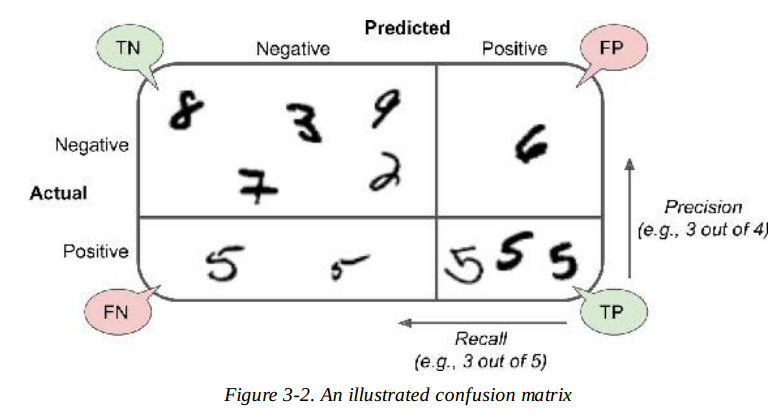

#### Precision and Recall

Scikit-Learn provides several functions to compute classifier metrics, including precision and recall:

In [ ]:
from sklearn.metrics import precision_score, recall_score

In [ ]:
precision_score(y_train_5, y_train_pred)  # == 4344 / (4344 + 1307)

In [ ]:
recall_score(y_train_5, y_train_pred)  # == 4344 / (4344 + 1077)

Now your 5-detector does not look as shiny as it did when you looked at its accuracy: 

It claims an image represents a 5, it is correct only 77% of the time. 

It only detects 80% of the 5s.

It is often convenient to combine precision and recall into a single metric called the **F1 score**, in particular if you need a simple way to compare two classifiers. 

The F1 score is the *harmonic mean* of precision and recall. Whereas the regular mean treats all values equally, **the harmonic mean gives much more weight to low values**. 

A classifier will only get a high F1 score if both recall and precision are high.

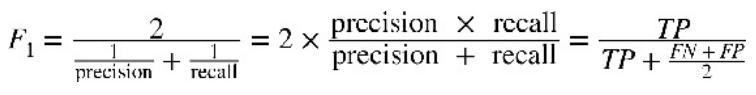

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
f1_score(y_train_5, y_train_pred)

The F 1 score favors classifiers that have *similar precision and recall*. 

This is not always what you want:

In some contexts **you mostly care about precision**:

For example, if you trained a classifier to detect videos that are safe for kids, you would probably prefer a classifier that rejects many good videos (low recall) but keeps only safe ones (high precision), rather than a classifier that has a much higher recall but lets a few really bad videos show up in your product (in such cases, you may even want to add a human pipeline to check the classifier’s video selection). 

In other contexts **you really care about recall**:

Suppose you train a classifier to detect shoplifters on surveillance images: it is probably fine if your classifier has only 30% precision as long as it has 99% recall (sure, the security guards will get a few false alerts, but almost all shoplifters will get caught).

**You can’t have it both ways: increasing precision reduces recall, and vice versa. This is
called the *precision/recall tradeoff.***

#### Precision/Recall Tradeoff

To understand this tradeoff, let’s look at how the *SGDClassifier* makes its classification decisions. 

For each instance, it computes a **score based on a decision function**, and if that score is greater than **a threshold**, it assigns the instance to the positive class, or else it assigns it to the negative class. 

Figure 3-3
shows a few digits positioned from the lowest score on the left to the highest score on the right. Suppose
the decision threshold is positioned at the central arrow (between the two 5s): you will find 4 true
positives (actual 5s) on the right of that threshold, and one false positive (actually a 6). Therefore, with
that threshold, the precision is 80% (4 out of 5). But out of 6 actual 5s, the classifier only detects 4, so the
recall is 67% (4 out of 6). Now if you raise the threshold (move it to the arrow on the right), the false
positive (the 6) becomes a true negative, thereby increasing precision (up to 100% in this case), but one
true positive becomes a false negative, decreasing recall down to 50%. Conversely, lowering the
threshold increases recall and reduces precision.

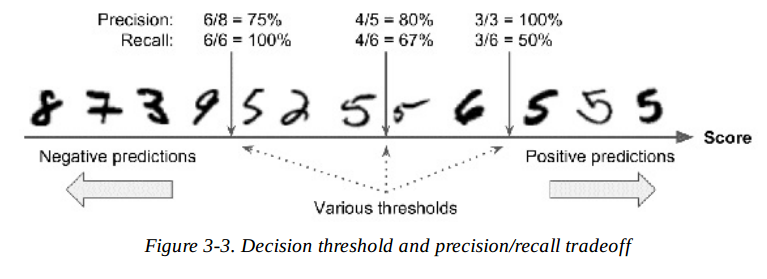

Scikit-Learn does not let you *set the threshold directly*, but it does give you access to the **decision scores** that it uses to make predictions. 

Instead of calling the classifier’s `predict()` method, you can call its **`decision_function()`** method, which *returns a score for each instance*, and then make predictions based on those scores using any threshold you want:

In [ ]:
y_scores = sgd_clf.decision_function([some_digit])

In [ ]:
y_scores

In [ ]:
threshold = 0

In [ ]:
y_some_digit_pred = y_scores > threshold

The *SGDClassifier* uses a **threshold equal to 0**, so the previous code returns the same result as the predict() method (i.e., True). Let’s raise the threshold:

In [ ]:
threshold = 200000
y_some_digit_pred = y_scores > threshold

In [ ]:
y_some_digit_pred

This confirms that **raising the threshold decreases recall**. 

The image actually represents a 5, and the classifier detects it when the threshold is 0, but it misses it when the threshold is increased to 200,000.

So how can you decide which threshold to use?

For this you will first need to get the scores of all instances in the training set using the `cross_val_predict()` function again, but this time specifying that you want it to return decision scores instead of predictions:

In [ ]:
y_scores = cross_val_predict(
    sgd_clf, X_train, y_train_5, cv=3, method="decision_function"
)

Now with these scores you can compute precision and recall for all possible thresholds using the `precision_recall_curve()` function:

In [ ]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Plot the curve:

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])

In [ ]:
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

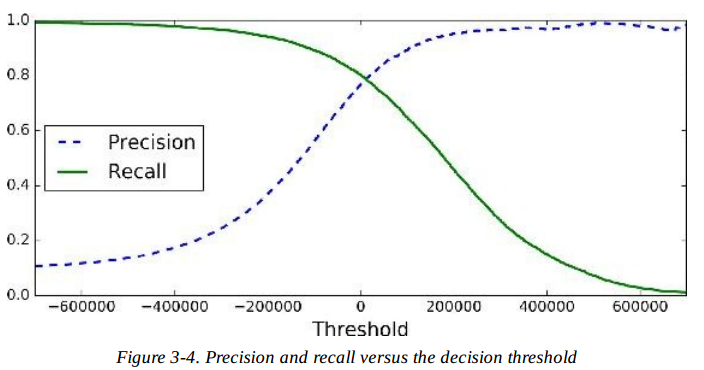

You may wonder why the precision curve is **bumpier** than the recall curve in Figure 3-4. The reason is that precision may sometimes go down when you raise the threshold (although in general it will go up). 

To understand why, look back at Figure 3-3 and notice what happens when you start from the central threshold and move it just one digit to the right: precision goes from 4/5
(80%) down to 3/4 (75%). 

On the other hand, recall can only go down when the threshold is increased, which explains why its curve looks smooth.

Now you can simply *select the threshold value that gives you the best precision/recall tradeoff* for your task. 

Another way to select a good precision/recall tradeoff is to plot precision directly against recall.

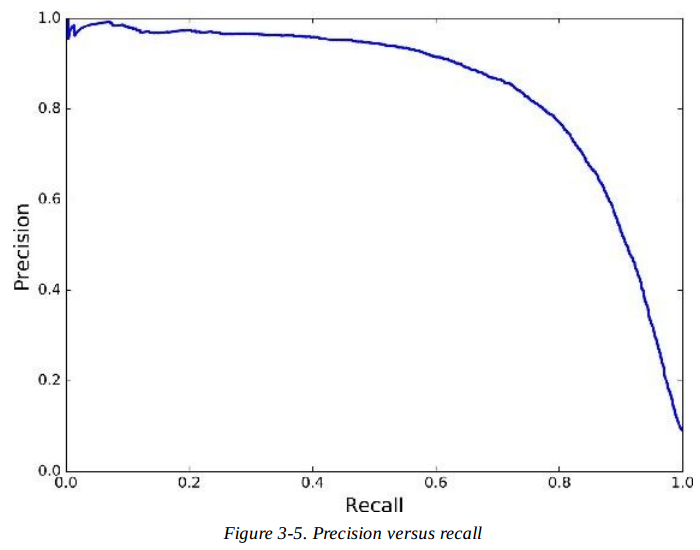

You can see that precision really starts to *fall sharply around 80% recall*. 

You will probably want to **select a precision/recall tradeoff just before that drop** — for example, at around 60% recall. But of course the choice **depends on your project**.

Let’s suppose you decide to aim for 90% precision. You look up the first plot and find that you need to use a threshold of about 70,000. To make predictions (on the training set for now),
instead of calling the classifier’s predict() method, you can just run this code: 

In [ ]:
y_train_pred_90 = y_scores > 70000

In [ ]:
precision_score(y_train_5, y_train_pred_90)

In [ ]:
recall_score(y_train_5, y_train_pred_90)

As you can see, it is fairly easy to create a classifier with **virtually any precision you want**: just set a high enough threshold, and you’re done. 

A high-precision classifier is not very useful if its recall is too low!


*If someone says “let’s reach 99% precision,” you should ask, “at what recall?”*

#### The ROC Curve

The *receiver operating characteristic* (ROC) curve is another common tool used with binary classifiers.

The ROC curve plots the **true positive rate (another name for recall)** against the **false positive rate**. 

The FPR is the ratio of negative instances that are incorrectly classified as positive. 

It is equal to 1-TNR, which is the ratio of negative instances that are correctly classified as negative. 

The TNR is also called *specificity*. Hence the ROC curve plots *sensitivity* (recall) versus 1–specificity.

To plot the ROC curve, you first need to compute the **TPR** and **FPR** for various threshold values, using the `roc_curve()` function:

In [ ]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

Then you can plot the FPR against the TPR using Matplotlib:

In [ ]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--")
    plt.axis([0, 1, 0, 1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

In [ ]:
plot_roc_curve(fpr, tpr)
plt.show()

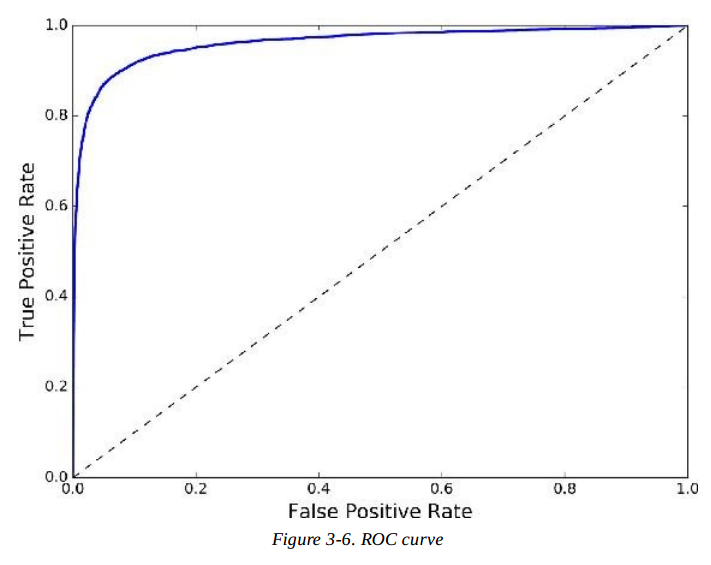

Once again there is a tradeoff: 
the higher the recall (TPR), the more false positives (FPR) the classifier produces. 

The dotted line represents the ROC curve of a **purely random classifier**; a good classifier stays as far away from that line as possible (toward the top-left corner).

One way to compare classifiers is to measure the **area under the curve (AUC)**. 

A perfect classifier will have a ROC AUC equal to 1, whereas a purely random classifier will have a ROC AUC equal to 0.5.

Scikit-Learn provides a function to compute the ROC AUC:

In [ ]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

Since the ROC curve is so similar to the precision/recall (or PR) curve, you may wonder "how to decide which one to use?" 


As a rule of thumb, you **should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives, and the ROC curve otherwise.**

For example, looking at the previous ROC curve (and the ROC AUC score), you may think that the classifier is really good. But this is mostly because there are few positives (5s) compared to
the negatives (non-5s).

In contrast, the PR curve makes it clear that the classifier has room for improvement (the curve could be closer to the top-right corner)

### Improve the classifier

Let’s train a *RandomForestClassifier* and compare its ROC curve and ROC AUC score to the
*SGDClassifier*. 

First, you need to get scores for each instance in the training set. But due to the way it
works, the RandomForestClassifier class does not have a `decision_function()` method. 

Instead it has a `predict_proba()` method. 
Scikit-Learn classifiers generally have one or the other. The `predict_proba()` method returns an array containing **a row per instance** and **a column per class**, each containing the probability that the given instance belongs to the given class (e.g., 70% chance that the image represents a 5):

But to plot a ROC curve, you need scores, not probabilities. A simple solution is to use the **positive class’s probability** as the score:

In [ ]:
y_scores_forest = y_probas_forest[:, 1]  # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

Now you are ready to plot the ROC curve. It is useful to plot the first ROC curve as well to see how they compare 

In [ ]:
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

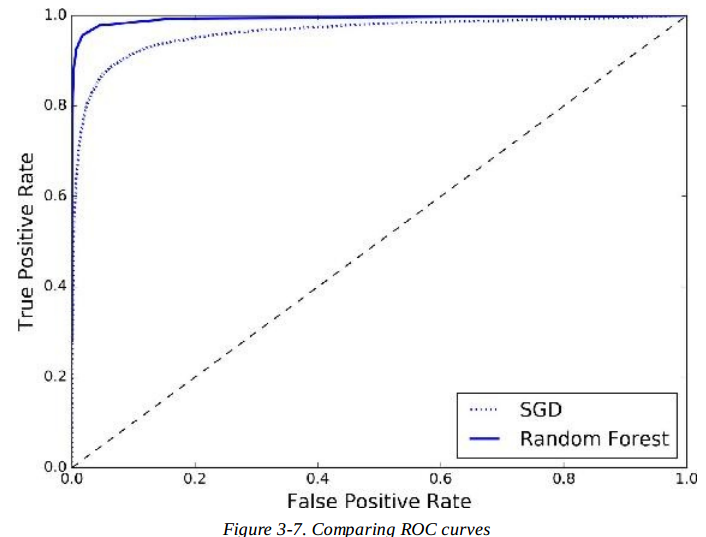

In [ ]:
roc_auc_score(y_train_5, y_scores_forest)

## Multiclass Classification

Some algorithms (such as Random Forest classifiers or naive Bayes classifiers) are capable of handling multiple classes directly. 

Others (such as Support Vector Machine classifiers or Linear classifiers) are strictly binary classifiers. 

There are various strategies that you can use to perform multiclass classification using multiple binary classifiers.

**one-versus-all (OvA) strategy (also called one-versus-the-rest)**:

Train 10 binary classifiers, one for each digit (a 0-detector, a 1-detector, a 2-detector, and so on). Then when you want to classify an image, you get the decision score from each classifier for that image and you **select the class whose classifier outputs the highest score**. 

**one-versus-one (OvO) strategy**:
Train a binary classifier for every pair of digits: one to distinguish 0s and 1s, another to distinguish 0s and 2s, another for 1s and 2s, and so on. 

If there are N classes, you need to train N × (N – 1) / 2 classifiers. For the MNIST problem, this means training 45 binary classifiers! When you want to classify an image, you have to run
the image through all 45 classifiers and see **which class wins the most duels.**
The main **advantage of OvO** is that each classifier **only needs to be trained on the part of the training set for the two classes that it must distinguish**.

Some algorithms (such as Support Vector Machine classifiers) scale poorly with the size of the training set, so for these algorithms **OvO is preferred** since it is faster to train many  classifiers on small training sets than training few classifiers on large training sets. 

For most binary classification algorithms OvA is preferred.

Scikit-Learn detects when you try to use a binary classification algorithm for a multiclass classification task, and **it automatically runs OvA** (except for SVM classifiers for which it uses OvO). Let’s try this with the *SGDClassifier*:

In [ ]:
sgd_clf.fit(X_train, y_train)  # y_train, not y_train_5
sgd_clf.predict([some_digit])

Then it makes a prediction (a correct one in this case). Under the hood, Scikit-Learn **actually trained 10 binary classifiers**, got their decision scores for the image, and selected the class with the highest score.

You can call the `decision_function()` method to see that this is indeed the case. Instead of returning just one score per instance, it now returns 10 scores, one per class:

In [ ]:
some_digit_scores = sgd_clf.decision_function([some_digit])

In [ ]:
some_digit_scores

The highest score is indeed the one corresponding to class 5:

In [ ]:
np.argmax(some_digit_scores)

In [ ]:
sgd_clf.classes_

In [ ]:
sgd_clf.classes_[5]

If you want to force ScikitLearn to use one-versus-one or one-versus-all, you can use the **OneVsOneClassifier** or **OneVsRestClassifier** classes: 

Simply create an instance and pass a binary classifier to its constructor. 

For example, this code creates a *multiclass classifier* using the *OvO strategy*, based on a *SGDClassifier*:

In [ ]:
from sklearn.multiclass import OneVsOneClassifier

ovo_clf = OneVsOneClassifier(SGDClassifier(random_state=42))
ovo_clf.fit(X_train, y_train)

In [ ]:
ovo_clf.predict([some_digit])

In [ ]:
len(ovo_clf.estimators_)

Training a *RandomForestClassifier* is just as easy:

In [ ]:
forest_clf.fit(X_train, y_train)

In [ ]:
forest_clf.predict([some_digit])

This time Scikit-Learn did not have to run OvA or OvO because Random Forest classifiers **can directly classify instances into multiple classes**. You can call `predict_proba()` to get the list of probabilities that the classifier assigned to each instance for each class:

In [ ]:
forest_clf.predict_proba([some_digit])

The classifier is fairly confident about its prediction: the 0.8 at the 5th index in the array means that the model estimates an 80% probability that the image represents a 5. It also thinks  that the image could instead be a 0 or a 3 (10% chance each).

Now of course you want to evaluate these classifiers. As usual, you want to use cross-validation. Let’s evaluate the SGDClassifier’s accuracy using the `cross_val_score()` function:

In [ ]:
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

It gets over 84% on all test folds. If you used a random classifier, you would get 10% accuracy, so this is not such a bad score, but you can still do much better. 
For example, simply scaling the inputs increases accuracy above 90%:

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [ ]:
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

## Error Analysis

Of course, if this were a real project, you would follow the steps in your Machine Learning project checklist (see Appendix B): 

* exploring data preparation options
* trying out multiple models
* shortlisting the best ones and fine-tuning their hyperparameters using `GridSearchCV`, and automating as much as possible. 

Here, we will assume that you have found a promising model and you want to find ways to improve it. One way to do this is to **analyze the types of errors** it makes.

First, you can look at the confusion matrix.

In [ ]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)

In [ ]:
conf_mx

It’s often more convenient to look at an image representation of the confusion matrix, using Matplotlib’s `matshow()` function:

In [ ]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

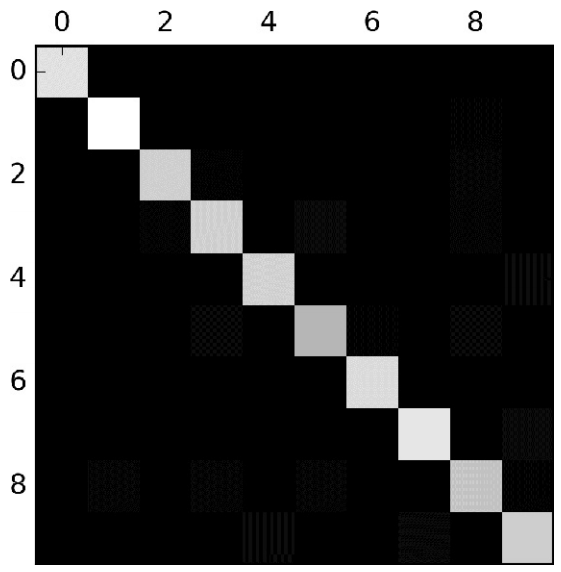

The 5s look slightly darker than the other digits, which could mean that:
    
* there are fewer images of 5s in the dataset or that 

* the classifier does not perform as well on 5s as on other digits. 

In fact, you can verify that both are the case.

Let’s focus the plot on the errors. 
First, you need to **divide each value in the confusion matrix by the number of images in the corresponding class**, so you can compare *error rates* instead of absolute number of errors (which would make abundant classes look unfairly bad):

In [ ]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

Now let’s fill the diagonal with zeros to keep only the errors, and let’s plot the result:

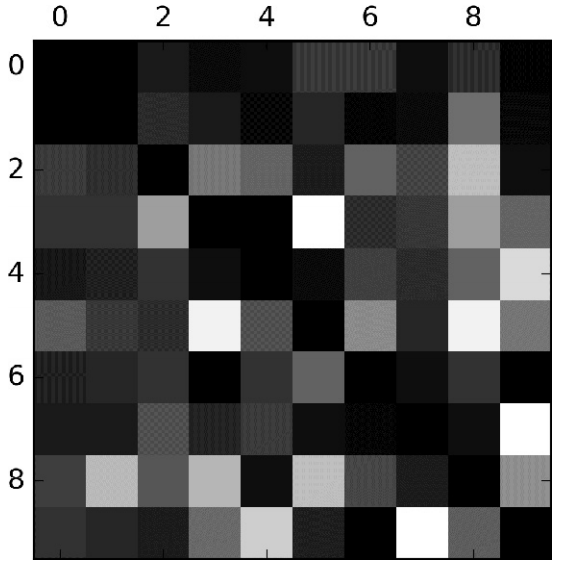

You can clearly see the kinds of errors the classifier makes. 
Remember that **rows represent actual classes**, while **columns** represent **predicted classes**. 

The columns for classes 8 and 9 are quite bright, which tells you that **many images get misclassified as 8s or 9s**.

Similarly, the rows for classes 8 and 9 are also quite bright, telling you that 8s and 9s are often confused with other digits. 

Conversely, some rows are pretty dark, such as row 1: this means that most 1s are classified correctly (a few are confused with 8s, but that’s about it). 

Notice that **the errors are not perfectly symmetrical**; for example, there are more 5s
misclassified as 8s than the reverse.

Looking at this plot, it seems that **your efforts should be spent on improving classification of 8s and 9s**, as well as fixing the specific 3/5 confusion. 

For example, *you could try to gather more training data for these digits*.

Or you could engineer new features that would help the classifier — for example, writing an algorithm to count the number of closed loops (e.g., 8 has two, 6 has one, 5 has none).

Or you could preprocess the images (e.g., using Scikit-Image, Pillow, or OpenCV) to make some patterns stand out more, such as closed loops.

Analyzing individual errors can also be a good way to **gain insights on what your classifier is doing and why it is failing, but it is more difficult and time-consuming**. 

For example, let’s plot examples of 3s and 5s (the `plot_digits()` function just uses Matplotlib’s `imshow()` function

In [ ]:
cl_a, cl_b = 3, 5

X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

plt.figure(figsize=(8, 8))
plt.subplot(221)
plot_digits(X_aa[:25], images_per_row=5)
plt.subplot(222)
plot_digits(X_ab[:25], images_per_row=5)
plt.subplot(223)
plot_digits(X_ba[:25], images_per_row=5)
plt.subplot(224)
plot_digits(X_bb[:25], images_per_row=5)
plt.show()

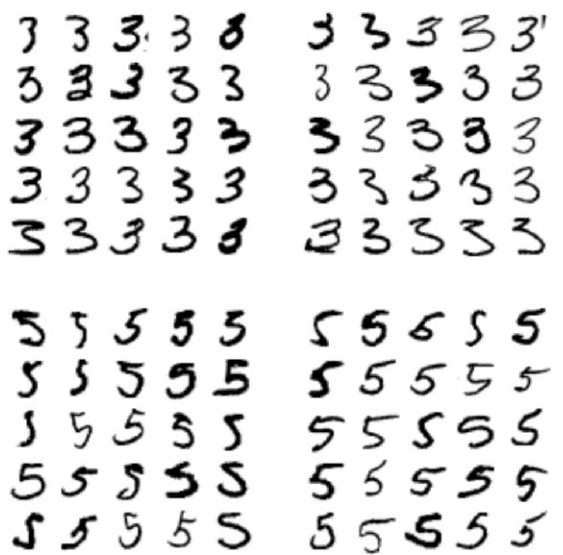

The two 5×5 blocks on the left show digits classified as 3s, and the two 5×5 blocks on the right show images classified as 5s. 

Some of the digits that the classifier gets wrong (i.e., in the bottom-left and topright blocks) are so badly written that even a human would have trouble classifying them (e.g., the 5 on the 8th row and 1st column truly looks like a 3). 

However, most misclassified images seem like obvious errors to us, and it’s hard to understand why the classifier made the mistakes it did. The reason is that we
used a simple SGDClassifier, which is a linear model. All it does is assign a weight per class to each pixel, and when it sees a new image it just sums up the weighted pixel intensities to get a score for each class. 

So since 3s and 5s differ only by a few pixels, this model will easily confuse them.
The main difference between 3s and 5s is the position of the small line that joins the top line to the bottom arc. If you draw a 3 with the junction slightly shifted to the left, the classifier might classify it as a 5, and vice versa. 

In other words, this classifier is quite sensitive to **image shifting and rotation**. So one way to reduce the 3/5 confusion would be to preprocess the images to **ensure that they are well centered and not too rotated**. This will probably help reduce other errors as well.

## Multilabel Classification

In some cases you may want your classifier to output multiple classes for each instance: 

For example, consider a face-recognition classifier: what should it do if it recognizes several people on the same picture? Of course it should attach one label per person it recognizes. Say the classifier has been trained to recognize three faces, Alice, Bob, and Charlie; then when it is shown a picture of Alice and Charlie, it should output [1, 0, 1]
(meaning “Alice yes, Bob no, Charlie yes”). 

Such a classification system that outputs **multiple binary labels** is called a **multilabel classification** system.

Let’s look at a simpler example, just for illustration purposes:

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

y_train_large = y_train >= 7
y_train_odd = y_train % 2 == 1
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

This code creates a `y_multilabel` array containing two target labels for each digit image: 

* The first indicates whether or not the digit is large (7, 8, or 9) 
* The second indicates whether or not it is odd.

The next lines create a KNeighborsClassifier instance (which **supports multilabel classification**, but not all classifiers do) and we train it using the multiple targets array. 

Now you can make a prediction, and notice that it outputs two labels:

In [ ]:
knn_clf.predict([some_digit])

The digit 5 is indeed not large (False) and odd (True).

There are many ways to evaluate a multilabel classifier, and selecting the right metric really *depends on your project*. 

One approach is to measure the F1 score for each individual label (or any other binary classifier metric discussed earlier), then simply compute the average score. 

This code computes the average F1 score across all labels:

In [ ]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)

In [ ]:
f1_score(y_train, y_train_knn_pred, average="macro")

This assumes that all labels are **equally important**, which may not be the case. 

In particular, if you have many more pictures of Alice than of Bob or Charlie, you may want to give more weight to the classifier’s score on pictures of Alice. 

One simple option is to **give each label a weight equal to its support** (i.e., the number of instances with that target label). To do this, simply set `average="weighted"` in the preceding
code

### Multioutput Classification

Multioutput-Multiclass classification (or simply multioutput classification) is simply a generalization of **multilabel classification where each label can be multiclass** (i.e., it can have more than two possible values).

To illustrate this, let’s build a system that **removes noise from images**. 

It will take as input a *noisy digit image*, and it will (hopefully) output a clean digit image, represented as an array of pixel intensities, just like the MNIST images. 

Notice that the classifier’s output is multilabel (one label per pixel) and each label can have multiple values (pixel intensity ranges from 0 to 255). It is thus an example of a multioutput
classification system.

The line between classification and regression is sometimes blurry, such as in this example. Arguably, predicting pixel intensity is more akin to regression than to classification.

Moreover, multioutput systems are not limited to classification tasks; you could even have a system that outputs multiple labels per instance, including both class labels and value labels

Let’s start by creating the training and test sets by taking the MNIST images and adding noise to their pixel intensities using NumPy’s `randint()` function. 

The target images will be the original images:

In [ ]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise

noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test

Let’s take a peek at an image from the test set (yes, we’re snooping on the test data, so you should be frowning right now):

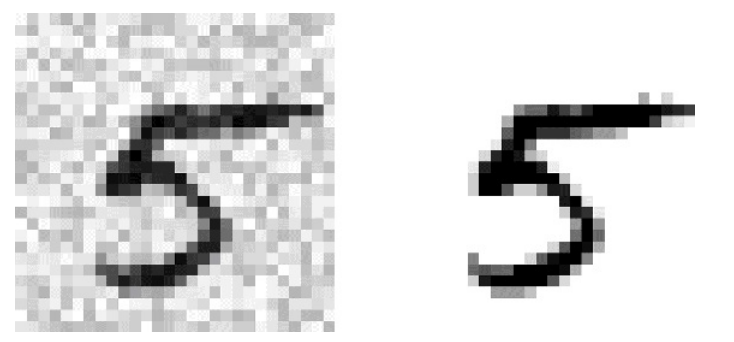

Now let’s train the classifier and make it clean this image:

In [ ]:
knn_clf.fit(X_train_mod, y_train_mod)
clean_digit = knn_clf.predict([X_test_mod[some_index]])
plot_digit(clean_digit)

Looks close enough to the target! 

Exercises

1. Try to build a classifier for the MNIST dataset that achieves over 97% accuracy on the test set. Hint: the KNeighborsClassifier works quite well for this task; you just need to find good hyperparameter values (try a grid search on the weights and n_neighbors hyperparameters).

2. Write a function that can shift an MNIST image in any direction (left, right, up, or down) by one pixel.5 Then, for each image in the training set, create four shifted copies (one per direction) and add them to the training set. Finally, train your best model on this expanded training set and measure its accuracy on the test set. You should observe that your model performs even better now! This technique of artificially growing the training set is called data augmentation or training set expansion.

3. Tackle the Titanic dataset. A great place to start is on Kaggle.

4. Build a spam classifier (a more challenging exercise):
* Download examples of spam and ham from Apache SpamAssassin’s public datasets.
* Unzip the datasets and familiarize yourself with the data format.
* Split the datasets into a training set and a test set.
* Write a data preparation pipeline to convert each email into a feature vector. Your preparation pipeline should transform an email into a (sparse) vector indicating the presence or absence of each possible word. For example, if all emails only ever contain four words, “Hello,” “how,” “are,” “you,” then the email “Hello you Hello Hello you” would be converted into a vector [1, 0, 0, 1] (meaning [“Hello” is present, “how” is absent, “are” is absent, “you” is present]), or [3, 0, 0, 2] if you prefer to count the number of occurrences of each word.

* You may want to add hyperparameters to your preparation pipeline to control whether or not to strip off email headers, convert each email to lowercase, remove punctuation, replace all URLs with “URL,” replace all numbers with “NUMBER,” or even perform stemming (i.e., trim off word endings; there are Python libraries available to do this).

* Then try out several classifiers and see if you can build a great spam classifier, with both high recall and high precision.

Solutions to these exercises are available in the online Jupyter notebooks at
https://github.com/ageron/handson-ml.